In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os, numpy as np, pandas as pd, tensorflow as tf
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
!ls /kaggle/input/celeba-dataset | head
!ls /kaggle/input/hat-or-no-hat-that-is-the-question-fall-25/test_set | head

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import tensorflow as tf


img_align_celeba
list_attr_celeba.csv
list_bbox_celeba.csv
list_eval_partition.csv
list_landmarks_align_celeba.csv
test_set


In [11]:
COMP_TEST_DIR = "/kaggle/input/hat-or-no-hat-that-is-the-question-fall-25/test_set/test_set"
CELEBA_ATTR = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
CELEBA_IMG_DIR = "/kaggle/input/celeba-dataset/img_align_celeba"

IMG_SIZE = (160, 160)
BATCH = 32 #Better for the T4/P100
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

print("TF:", tf.__version__)
!nvidia-smi -L

TF: 2.18.0
GPU 0: Tesla T4 (UUID: GPU-90c6a0d4-b986-cc23-e452-ec18382e090e)
GPU 1: Tesla T4 (UUID: GPU-8787af17-3fa1-0801-5d41-dd5b9c7cbfa7)


In [12]:
# inspect attributes 
df = pd.read_csv(CELEBA_ATTR)  # Jessica Li dump is CSV with header
print("First 5 columns:", list(df.columns)[:5], " ... total cols:", len(df))
print("Sample rows:\n", df.head(3))

# Which column is the filename?
fname = "image_id" if "image_id" in df.columns else ("filename" if "filename" in df.columns else df.columns[0])
print("Filename column chosen:", fname)

# Wearing_Hat sanity
print("Wearing_Hat in columns?", "Wearing_Hat" in df.columns)
print("Wearing_Hat unique (first 10):", pd.unique(df["Wearing_Hat"])[:10])

# Inspect image directory shape
def count_jpgs(d): 
    try: return len(glob(str(Path(d)/"*.jpg")))
    except: return 0

candidates = [
    CELEBA_IMG_DIR,
    str(Path(CELEBA_IMG_DIR)/"img_align_celeba"),   # some dumps nest a second folder
]
for d in candidates:
    print("Dir:", d, "jpg count:", count_jpgs(d))


First 5 columns: ['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes']  ... total cols: 202599
Sample rows:
      image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                

## Building a small balanced train/val set from CelebA 

In [13]:
# Auto-fix loader + safe sampling
# 1) Clean columns
df = pd.read_csv(CELEBA_ATTR)
fname = "image_id" if "image_id" in df.columns else ("filename" if "filename" in df.columns else df.columns[0])
df = df.rename(columns={fname: "filename"})

# 2) Normalize Wearing_Hat to int {1, -1}
def to_int(x):
    try: return int(str(x).strip())
    except: return np.nan
df["Wearing_Hat"] = df["Wearing_Hat"].apply(to_int)
df = df.dropna(subset=["Wearing_Hat"]).copy()
df["label"] = np.where(df["Wearing_Hat"] == 1, "Hat", "No Hat")

# 3) Detect the real images folder (handles nested img_align_celeba/img_align_celeba)
img_dir_candidates = [
    Path(CELEBA_IMG_DIR),
    Path(CELEBA_IMG_DIR) / "img_align_celeba",
]
IMG_DIR = None
for d in img_dir_candidates:
    if len(list(d.glob("*.jpg"))) > 0:
        IMG_DIR = d
        break
if IMG_DIR is None:
    raise FileNotFoundError("Could not find any .jpg files in the expected image directories.")

# 4) Build full paths and keep only existing files
df["path"] = df["filename"].apply(lambda f: str(IMG_DIR / f))
exists_mask = df["path"].apply(os.path.exists)
print("Files found on disk:", exists_mask.sum(), "/", len(df))
df = df[exists_mask].reset_index(drop=True)

# 5) Class counts + SAFE sampling
hat_df, nohat_df = df[df.label=="Hat"], df[df.label=="No Hat"]
print("Counts → Hat:", len(hat_df), "No Hat:", len(nohat_df))
TARGET = 3000 
n = min(TARGET, len(hat_df), len(nohat_df))
if n == 0:
    raise ValueError("One class has zero samples after filtering. Check outputs above (paths/columns).")
pos = hat_df.sample(n=n, random_state=42)
neg = nohat_df.sample(n=n, random_state=42)
df_bal = pd.concat([pos, neg]).sample(frac=1.0, random_state=42).reset_index(drop=True)

# 6) Train/val split
cut = int(0.8 * len(df_bal))
train_df = df_bal.iloc[:cut].reset_index(drop=True)
val_df   = df_bal.iloc[cut:].reset_index(drop=True)

print("Final split:", len(train_df), "train /", len(val_df), "val")
print("Train balance:\n", train_df["label"].value_counts())





Files found on disk: 202599 / 202599
Counts → Hat: 9818 No Hat: 192781
Final split: 4800 train / 1200 val
Train balance:
 label
Hat       2422
No Hat    2378
Name: count, dtype: int64


## TF Datasets (with light aug)

In [14]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label=="Hat", tf.float32)

def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, label

def make_ds(frame, training=True):
    paths = frame["path"].values
    labels = frame["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p,l: load_image(p,l), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(4096, seed=SEED).map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)


## Model - MobileNetV2 head 

In [15]:
base = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE+(3,),
                                         include_top=False, weights="imagenet")
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=6, callbacks=callbacks, verbose=1)


Epoch 1/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - accuracy: 0.7919 - auc: 0.8620 - loss: 0.4207 - val_accuracy: 0.9408 - val_auc: 0.9826 - val_loss: 0.1705
Epoch 2/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9520 - auc: 0.9870 - loss: 0.1427 - val_accuracy: 0.9517 - val_auc: 0.9851 - val_loss: 0.1497
Epoch 3/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9550 - auc: 0.9876 - loss: 0.1344 - val_accuracy: 0.9558 - val_auc: 0.9865 - val_loss: 0.1398
Epoch 4/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9605 - auc: 0.9897 - loss: 0.1217 - val_accuracy: 0.9583 - val_auc: 0.9869 - val_loss: 0.1350
Epoch 5/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9578 - auc: 0.9923 - loss: 0.1095 - val_accuracy: 0.9500 - val_auc: 0.9882 - val_loss: 0.1400
Epoch 6/6
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9590 - auc: 0.9889 - loss: 0.1218 - val_accuracy: 0.9567 - val_auc: 0.9878 - val_loss: 0.1316


In [16]:
#Fine tuning 
for layer in base.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC()])

model.fit(train_ds, validation_data=val_ds, epochs=3, callbacks=callbacks, verbose=1)


Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - accuracy: 0.9122 - auc_1: 0.9742 - loss: 0.2217 - val_accuracy: 0.9575 - val_auc_1: 0.9878 - val_loss: 0.1322
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9558 - auc_1: 0.9896 - loss: 0.1296 - val_accuracy: 0.9558 - val_auc_1: 0.9888 - val_loss: 0.1371
Epoch 3/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9554 - auc_1: 0.9901 - loss: 0.1212 - val_accuracy: 0.9583 - val_auc_1: 0.9889 - val_loss: 0.1353


## Predict competition test set (Submisson.csv)

In [17]:
from glob import glob
import os, numpy as np, pandas as pd
from pathlib import Path
import tensorflow as tf

# Recursively find images under the test_set root
TEST_ROOT = "/kaggle/input/hat-or-no-hat-that-is-the-question-fall-25/test_set"
test_files = sorted(glob(str(Path(TEST_ROOT) / "**" / "*.jpg"), recursive=True))
print("Found test images:", len(test_files))
assert len(test_files) > 0, "No test .jpg files found. Check TEST_ROOT."

ids, preds = [], []

for p in test_files:
    img = tf.keras.utils.load_img(p, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)/255.0
    x = np.expand_dims(x, 0)
    prob = float(model.predict(x, verbose=0)[0][0])
    label = "Hat" if prob > 0.5 else "No Hat"
    ids.append(os.path.splitext(os.path.basename(p))[0])  # strip dir + .jpg
    preds.append(label)

sub = pd.DataFrame({"id": ids, "class": preds}).sort_values("id")
print(sub.head(), "\nrows:", len(sub), "unique ids:", sub['id'].nunique())
sub.to_csv("submission.csv", index=False)
print("Saved -> submission.csv")



Found test images: 1490
                                 id   class
0  00a7c4438e7c1b98a1625aff211bab50  No Hat
1  00b0e9a0f1e5bcaf03873b64d713a170     Hat
2  00e50b16ef632d8059b03a47153daf07  No Hat
3  013fafa82dda5970dd807bc46faf3f95  No Hat
4  017110f084e029eaee20aad780e4bfb6     Hat 
rows: 1490 unique ids: 1490
Saved -> submission.csv


## Plots for the report 

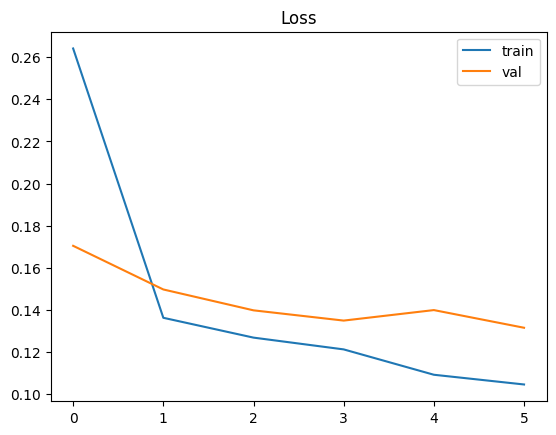

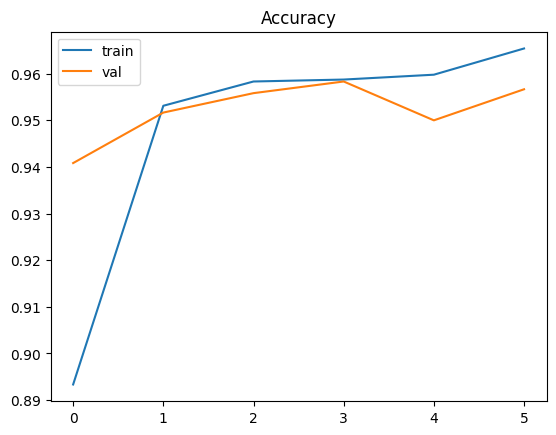

In [19]:
plt.figure(); 
plt.plot(history.history["loss"], label="train"); 
plt.plot(history.history["val_loss"], label="val"); 
plt.legend(); plt.title("Loss"); 
plt.savefig("loss.png"); plt.show()

plt.figure(); 
plt.plot(history.history["accuracy"], label="train"); 
plt.plot(history.history["val_accuracy"], label="val"); 
plt.legend(); plt.title("Accuracy"); 
plt.savefig("acc.png"); plt.show()
